In [1]:
import polars as pl 
import numpy as np
import pandas as pd
import missingno as msno
import matplotlib.pyplot as plt


from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score 


dataPath = "./home-credit-credit-risk-model-stability/"

In [2]:
def set_table_dtypes(df: pl.DataFrame) -> pl.DataFrame:
    # implement here all desired dtypes for tables
    # the following is just an example
    for col in df.columns:
        # last letter of column name will help you determine the type
        if col[-1] in ("P", "A"):
            df = df.with_columns(pl.col(col).cast(pl.Float64).alias(col))

    return df

def convert_strings(df: pd.DataFrame) -> pd.DataFrame:
    for col in df.columns:  
        if df[col].dtype.name in ['object', 'string']:
            df[col] = df[col].astype("string").astype('category')
            current_categories = df[col].cat.categories
            new_categories = current_categories.to_list() + ["Unknown"]
            new_dtype = pd.CategoricalDtype(categories=new_categories, ordered=True)
            df[col] = df[col].astype(new_dtype)
    return df

In [3]:
train_basetable = pl.read_csv(dataPath + "csv_files/train/train_base.csv")
train_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/train/train_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/train/train_static_0_1.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
train_static_cb = pl.read_csv(dataPath + "csv_files/train/train_static_cb_0.csv").pipe(set_table_dtypes)
train_person_1 = pl.read_csv(dataPath + "csv_files/train/train_person_1.csv").pipe(set_table_dtypes) 
train_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/train/train_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

In [4]:
test_basetable = pl.read_csv(dataPath + "csv_files/test/test_base.csv")
test_static = pl.concat(
    [
        pl.read_csv(dataPath + "csv_files/test/test_static_0_0.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_1.csv").pipe(set_table_dtypes),
        pl.read_csv(dataPath + "csv_files/test/test_static_0_2.csv").pipe(set_table_dtypes),
    ],
    how="vertical_relaxed",
)
test_static_cb = pl.read_csv(dataPath + "csv_files/test/test_static_cb_0.csv").pipe(set_table_dtypes)
test_person_1 = pl.read_csv(dataPath + "csv_files/test/test_person_1.csv").pipe(set_table_dtypes) 
test_credit_bureau_b_2 = pl.read_csv(dataPath + "csv_files/test/test_credit_bureau_b_2.csv").pipe(set_table_dtypes) 

Feature engineering

In this part, we can see a simple example of joining tables via case_id. Here the loading and joining is done with polars library. Polars library is blazingly fast and has much smaller memory footprint than pandas.

In [5]:
# We need to use aggregation functions in tables with depth > 1, so tables that contain num_group1 column or 
# also num_group2 column.
train_person_1_feats_1 = train_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

# Here num_group1=0 has special meaning, it is the person who applied for the loan.
train_person_1_feats_2 = train_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

# Here we have num_goup1 and num_group2, so we need to aggregate again.
train_credit_bureau_b_2_feats = train_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

# We will process in this examples only A-type and M-type columns, so we need to select them.
selected_static_cols = []
for col in train_static.columns:
    if col[-1] in ("A", "M"):
        selected_static_cols.append(col)
print(selected_static_cols)

selected_static_cb_cols = []
for col in train_static_cb.columns:
    if col[-1] in ("A", "M"):
        selected_static_cb_cols.append(col)
print(selected_static_cb_cols)

# Join all tables together.
data = train_basetable.join(
    train_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    train_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    train_person_1_feats_1, how="left", on="case_id"
).join(
    train_person_1_feats_2, how="left", on="case_id"
).join(
    train_credit_bureau_b_2_feats, how="left", on="case_id"
)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [6]:
test_person_1_feats_1 = test_person_1.group_by("case_id").agg(
    pl.col("mainoccupationinc_384A").max().alias("mainoccupationinc_384A_max"),
    (pl.col("incometype_1044T") == "SELFEMPLOYED").max().alias("mainoccupationinc_384A_any_selfemployed")
)

test_person_1_feats_2 = test_person_1.select(["case_id", "num_group1", "housetype_905L"]).filter(
    pl.col("num_group1") == 0
).drop("num_group1").rename({"housetype_905L": "person_housetype"})

test_credit_bureau_b_2_feats = test_credit_bureau_b_2.group_by("case_id").agg(
    pl.col("pmts_pmtsoverdue_635A").max().alias("pmts_pmtsoverdue_635A_max"),
    (pl.col("pmts_dpdvalue_108P") > 31).max().alias("pmts_dpdvalue_108P_over31")
)

data_submission = test_basetable.join(
    test_static.select(["case_id"]+selected_static_cols), how="left", on="case_id"
).join(
    test_static_cb.select(["case_id"]+selected_static_cb_cols), how="left", on="case_id"
).join(
    test_person_1_feats_1, how="left", on="case_id"
).join(
    test_person_1_feats_2, how="left", on="case_id"
).join(
    test_credit_bureau_b_2_feats, how="left", on="case_id"
)

In [7]:
case_ids = data["case_id"].unique().shuffle(seed=1)
case_ids_train, case_ids_test = train_test_split(case_ids, train_size=0.8, random_state=1)
#case_ids_valid, case_ids_test = train_test_split(case_ids_test, train_size=0.5, random_state=1)

cols_pred = []
for col in data.columns:
    if col[-1].isupper() and col[:-1].islower():
        cols_pred.append(col)

print(cols_pred)

def from_polars_to_pandas(case_ids: pl.DataFrame) -> pl.DataFrame:
    return (
        data.filter(pl.col("case_id").is_in(case_ids))[["case_id", "WEEK_NUM", "target"]].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))[cols_pred].to_pandas(),
        data.filter(pl.col("case_id").is_in(case_ids))["target"].to_pandas()
    )

base_train, X_train, y_train = from_polars_to_pandas(case_ids_train)
#base_valid, X_valid, y_valid = from_polars_to_pandas(case_ids_valid)
base_test, X_test, y_test = from_polars_to_pandas(case_ids_test)


#for df in [X_train, X_valid, X_test]:
#    df = convert_strings(df)

for df in [X_train, X_test]:
    df = convert_strings(df)

['amtinstpaidbefduel24m_4187115A', 'annuity_780A', 'annuitynextmonth_57A', 'avginstallast24m_3658937A', 'avglnamtstart24m_4525187A', 'avgoutstandbalancel6m_4187114A', 'avgpmtlast12m_4525200A', 'credamount_770A', 'currdebt_22A', 'currdebtcredtyperange_828A', 'disbursedcredamount_1113A', 'downpmt_116A', 'inittransactionamount_650A', 'lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastapprcredamount_781A', 'lastcancelreason_561M', 'lastotherinc_902A', 'lastotherlnsexpense_631A', 'lastrejectcommoditycat_161M', 'lastrejectcommodtypec_5251769M', 'lastrejectcredamount_222A', 'lastrejectreason_759M', 'lastrejectreasonclient_4145040M', 'maininc_215A', 'maxannuity_159A', 'maxannuity_4075009A', 'maxdebt4_972A', 'maxinstallast24m_3658928A', 'maxlnamtstart6m_4525199A', 'maxoutstandbalancel12m_4187113A', 'maxpmtlast3m_4525190A', 'previouscontdistrict_112M', 'price_1097A', 'sumoutstandtotal_3546847A', 'sumoutstandtotalest_4493215A', 'totaldebt_9A', 'totalsettled_863A', 'totinstallas

In [8]:
print(f"Train: {X_train.shape}, Type: {type(X_train)}")
print(f"Test: {X_test.shape}, Type: {type(X_test)}")

Train: (1221327, 48), Type: <class 'pandas.core.frame.DataFrame'>
Test: (305332, 48), Type: <class 'pandas.core.frame.DataFrame'>


In [9]:
print("Training in precentage:", len(X_train)/(len(X_train)  + len(X_test)))
print("Testing in precentage:", len(X_test)/(len(X_train) +  len(X_test)))

Training in precentage: 0.7999998689949753
Testing in precentage: 0.2000001310050247


In [10]:
print(f"Train: {base_train.shape}, Type: {type(base_train)}")
print(f"Test: {base_test.shape}, Type: {type(base_test)}")

Train: (1221327, 3), Type: <class 'pandas.core.frame.DataFrame'>
Test: (305332, 3), Type: <class 'pandas.core.frame.DataFrame'>


In [11]:
#print(y_train.head())

count_ones = len(y_train[y_train == 1])
print(count_ones)

count_zeros = len(y_train[y_train == 0])
print(count_zeros)

print("total: ", count_ones + count_zeros)



38351
1182976
total:  1221327


In [12]:
print(base_train)

         case_id  WEEK_NUM  target
0              0         0       0
1              1         0       0
2              2         0       0
3              5         0       0
4              6         0       0
...          ...       ...     ...
1221322  2703450        91       0
1221323  2703451        91       0
1221324  2703452        91       0
1221325  2703453        91       0
1221326  2703454        91       0

[1221327 rows x 3 columns]


In [13]:
print(y_train)

0          0
1          0
2          0
3          0
4          0
          ..
1221322    0
1221323    0
1221324    0
1221325    0
1221326    0
Name: target, Length: 1221327, dtype: int64


Visualise the inbalance dataset

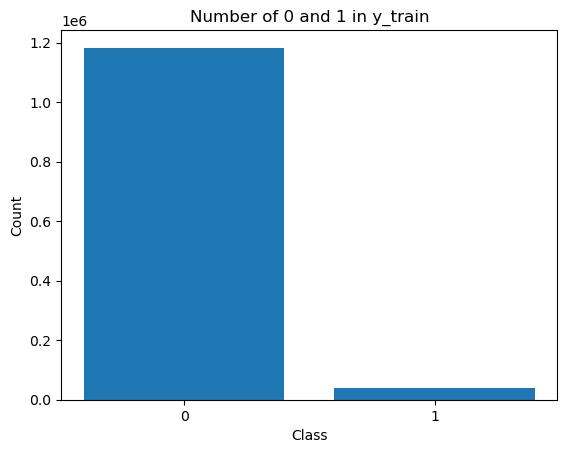

In [14]:
# Count the number of 0s and 1s
counts = y_train.value_counts()

# Create a bar chart
plt.bar(counts.index, counts.values)

# Label the x-axis and y-axis
plt.xlabel('Class')
plt.ylabel('Count')

# Add a title
plt.title('Number of 0 and 1 in y_train')

# Specify the x-axis tick marks
plt.xticks([0, 1])

# Show the plot
plt.show()

In [15]:
# Calculate the number of NaN values in the column
num_nan = X_train['amtinstpaidbefduel24m_4187115A'].isna().sum()
print("The number of NaN values in the column:", num_nan) #the number of NaN values in the column
print("The number of non-NaN values in the column:", 915995-num_nan) # the number of non-NaN values in the column

The number of NaN values in the column: 449043
The number of non-NaN values in the column: 466952


<Axes: >

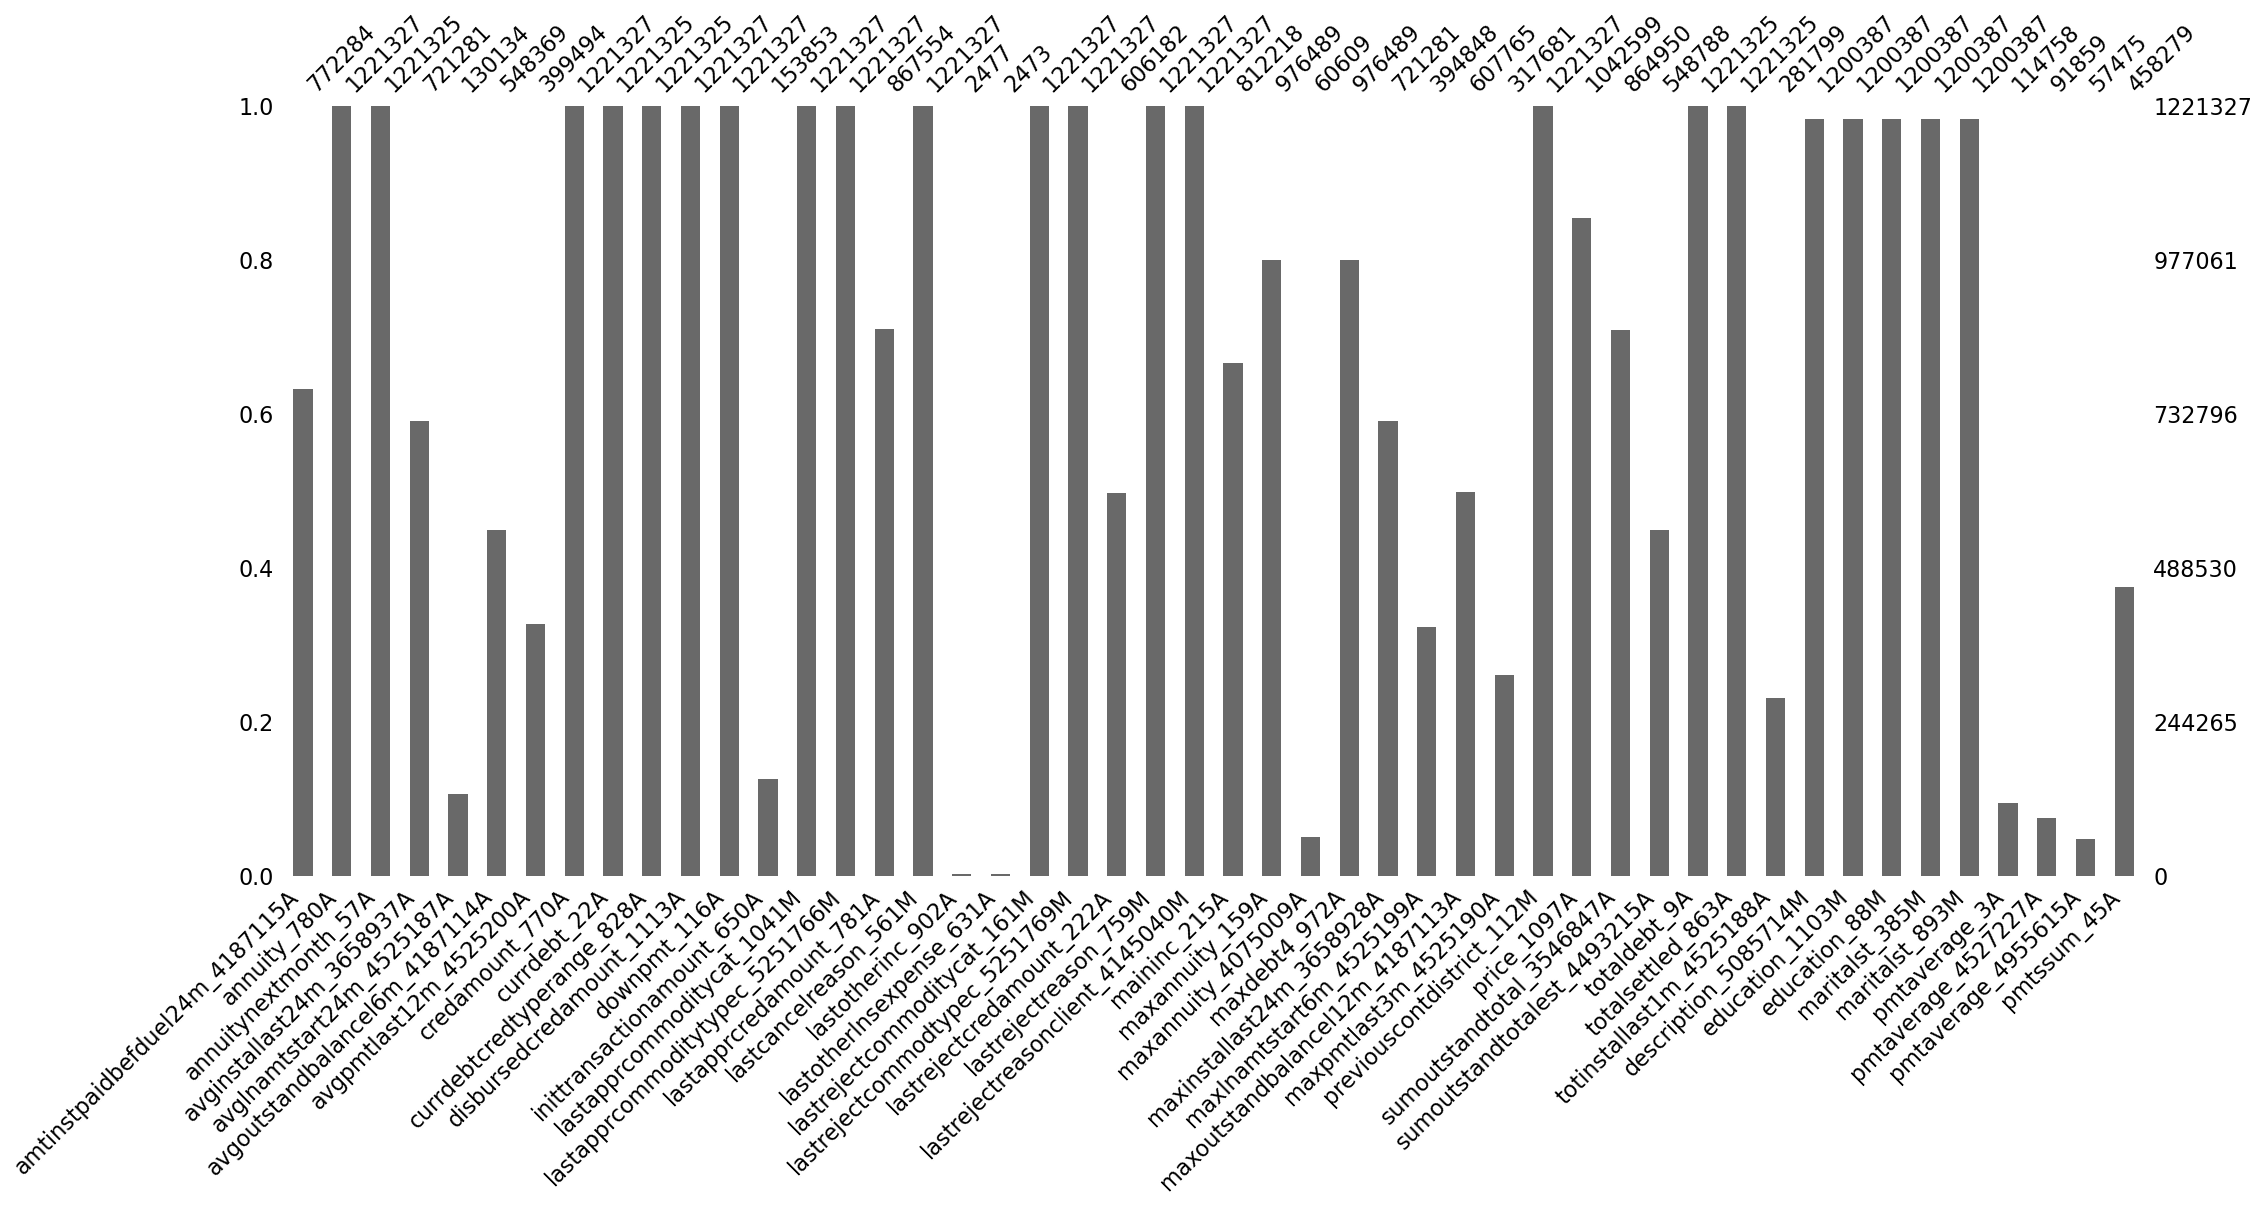

In [16]:
msno.bar(X_train)


In [17]:
# Create an empty DataFrame to store the results
result = pd.DataFrame(columns=['Column', 'Min Value'])

# Iterate over the columns
for col in X_train.columns:
    # Check if the column contains any NaN values
    if X_train[col].isna().any():
        # Get the minimum value in the column
        min_value = X_train[col].min()
        # Create a DataFrame with the column name and minimum value
        new_row = pd.DataFrame({'Column': [col], 'Min Value': [min_value]})
        # Concatenate the new row to the result DataFrame
        result = pd.concat([result, new_row], ignore_index=True)

# Display the result
print(result)

                             Column  Min Value
0    amtinstpaidbefduel24m_4187115A        0.0
1              annuitynextmonth_57A        0.0
2         avginstallast24m_3658937A        0.0
3         avglnamtstart24m_4525187A        0.0
4    avgoutstandbalancel6m_4187114A -7588198.5
5            avgpmtlast12m_4525200A        0.0
6                      currdebt_22A        0.0
7        currdebtcredtyperange_828A        0.0
8        inittransactionamount_650A        0.0
9           lastapprcredamount_781A        0.0
10                lastotherinc_902A        0.0
11         lastotherlnsexpense_631A        0.0
12        lastrejectcredamount_222A        0.0
13                     maininc_215A        0.0
14                  maxannuity_159A        0.0
15              maxannuity_4075009A      600.0
16                    maxdebt4_972A        0.0
17        maxinstallast24m_3658928A        0.0
18         maxlnamtstart6m_4525199A        0.0
19  maxoutstandbalancel12m_4187113A -7588198.5
20           

/var/folders/60/4pfs6t995613vlvnf3xtprtr0000gn/T/ipykernel_8337/3037250746.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, new_row], ignore_index=True)


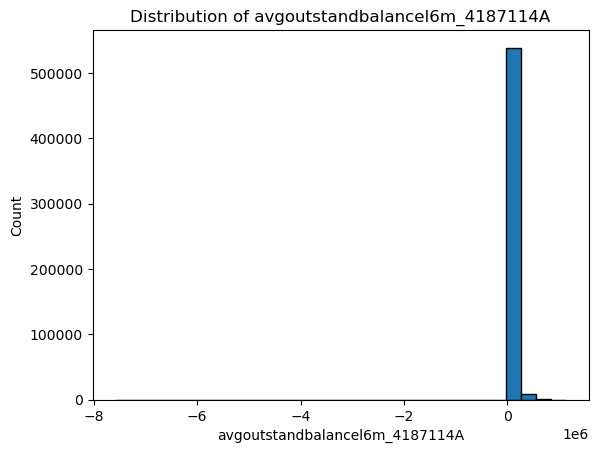

10411


In [18]:
import matplotlib.pyplot as plt

# Create a histogram of the 'lastapprcredamount_781A' column
plt.hist(X_train['avgoutstandbalancel6m_4187114A'], bins=30, edgecolor='black')

# Label the x-axis and y-axis
plt.xlabel('avgoutstandbalancel6m_4187114A')
plt.ylabel('Count')

# Add a title
plt.title('Distribution of avgoutstandbalancel6m_4187114A')

# Show the plot
plt.show()

# Count the number of negative values in the column
negative_count = (X_train['avgoutstandbalancel6m_4187114A'] < 0).sum()

print(negative_count)

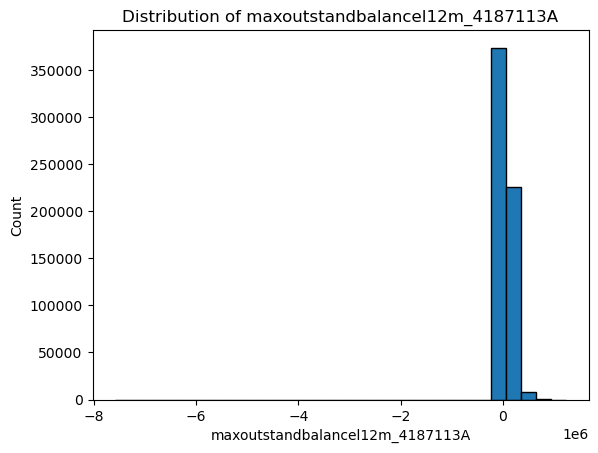

3302


In [19]:
import matplotlib.pyplot as plt

# Create a histogram of the 'lastapprcredamount_781A' column
plt.hist(X_train['maxoutstandbalancel12m_4187113A'], bins=30, edgecolor='black')

# Label the x-axis and y-axis
plt.xlabel('maxoutstandbalancel12m_4187113A')
plt.ylabel('Count')

# Add a title
plt.title('Distribution of maxoutstandbalancel12m_4187113A')

# Show the plot
plt.show()

# Count the number of negative values in the column
negative_count = (X_train['maxoutstandbalancel12m_4187113A'] < 0).sum()

print(negative_count)

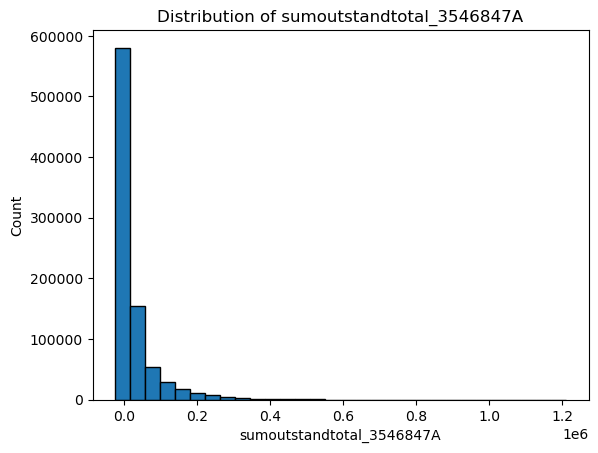

3


In [20]:
import matplotlib.pyplot as plt

# Create a histogram of the 'lastapprcredamount_781A' column
plt.hist(X_train['sumoutstandtotal_3546847A'], bins=30, edgecolor='black')

# Label the x-axis and y-axis
plt.xlabel('sumoutstandtotal_3546847A')
plt.ylabel('Count')

# Add a title
plt.title('Distribution of sumoutstandtotal_3546847A')

# Show the plot
plt.show()

# Count the number of negative values in the column
negative_count = (X_train['sumoutstandtotal_3546847A'] < 0).sum()

print(negative_count)

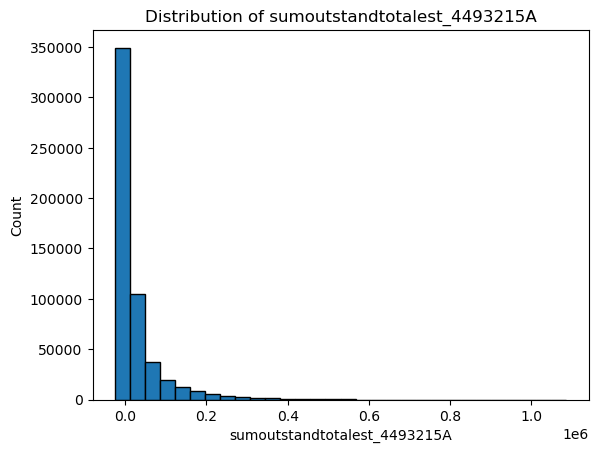

3


In [21]:
import matplotlib.pyplot as plt

# Create a histogram of the 'lastapprcredamount_781A' column
plt.hist(X_train['sumoutstandtotalest_4493215A'], bins=30, edgecolor='black')

# Label the x-axis and y-axis
plt.xlabel('sumoutstandtotalest_4493215A')
plt.ylabel('Count')

# Add a title
plt.title('Distribution of sumoutstandtotalest_4493215A')

# Show the plot
plt.show()

# Count the number of negative values in the column
negative_count = (X_train['sumoutstandtotalest_4493215A'] < 0).sum()

print(negative_count)

In [22]:
# Print the data types of all columns in X_train
print(X_train.dtypes)

amtinstpaidbefduel24m_4187115A      float64
annuity_780A                        float64
annuitynextmonth_57A                float64
avginstallast24m_3658937A           float64
avglnamtstart24m_4525187A           float64
avgoutstandbalancel6m_4187114A      float64
avgpmtlast12m_4525200A              float64
credamount_770A                     float64
currdebt_22A                        float64
currdebtcredtyperange_828A          float64
disbursedcredamount_1113A           float64
downpmt_116A                        float64
inittransactionamount_650A          float64
lastapprcommoditycat_1041M         category
lastapprcommoditytypec_5251766M    category
lastapprcredamount_781A             float64
lastcancelreason_561M              category
lastotherinc_902A                   float64
lastotherlnsexpense_631A            float64
lastrejectcommoditycat_161M        category
lastrejectcommodtypec_5251769M     category
lastrejectcredamount_222A           float64
lastrejectreason_759M           

In [23]:
print(X_train.shape)
print(y_train.shape)
print(base_train.shape)

(1221327, 48)
(1221327,)
(1221327, 3)


In [24]:
# Select only numeric columns
numeric_cols = X_train.select_dtypes(include=['int64', 'float64'])

# Find the indices of the rows with negative values in any numeric column
negative_indices = numeric_cols[numeric_cols.lt(0).any(axis=1)].index

# Remove these rows from X_train
X_train = X_train.drop(negative_indices)

# Remove the corresponding rows from y_test and base_train
y_train = y_train.drop(negative_indices)
base_train = base_train.drop(negative_indices)

In [25]:
# Create an empty DataFrame to store the results
result = pd.DataFrame(columns=['Column', 'Min Value'])

# Iterate over the columns
for col in X_train.columns:
    # Check if the column contains any NaN values
    if X_train[col].isna().any():
        # Get the minimum value in the column
        min_value = X_train[col].min()
        # Create a DataFrame with the column name and minimum value
        new_row = pd.DataFrame({'Column': [col], 'Min Value': [min_value]})
        # Concatenate the new row to the result DataFrame
        result = pd.concat([result, new_row], ignore_index=True)

# Display the result
print(result)

                             Column Min Value
0    amtinstpaidbefduel24m_4187115A       0.0
1              annuitynextmonth_57A       0.0
2         avginstallast24m_3658937A       0.0
3         avglnamtstart24m_4525187A       0.0
4    avgoutstandbalancel6m_4187114A       0.0
5            avgpmtlast12m_4525200A       0.0
6                      currdebt_22A       0.0
7        currdebtcredtyperange_828A       0.0
8        inittransactionamount_650A       0.0
9           lastapprcredamount_781A       0.0
10                lastotherinc_902A       0.0
11         lastotherlnsexpense_631A       0.0
12        lastrejectcredamount_222A       0.0
13                     maininc_215A       0.0
14                  maxannuity_159A       0.0
15              maxannuity_4075009A     600.0
16                    maxdebt4_972A       0.0
17        maxinstallast24m_3658928A       0.0
18         maxlnamtstart6m_4525199A       0.0
19  maxoutstandbalancel12m_4187113A       0.0
20            maxpmtlast3m_4525190

/var/folders/60/4pfs6t995613vlvnf3xtprtr0000gn/T/ipykernel_8337/3037250746.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  result = pd.concat([result, new_row], ignore_index=True)


<Axes: >

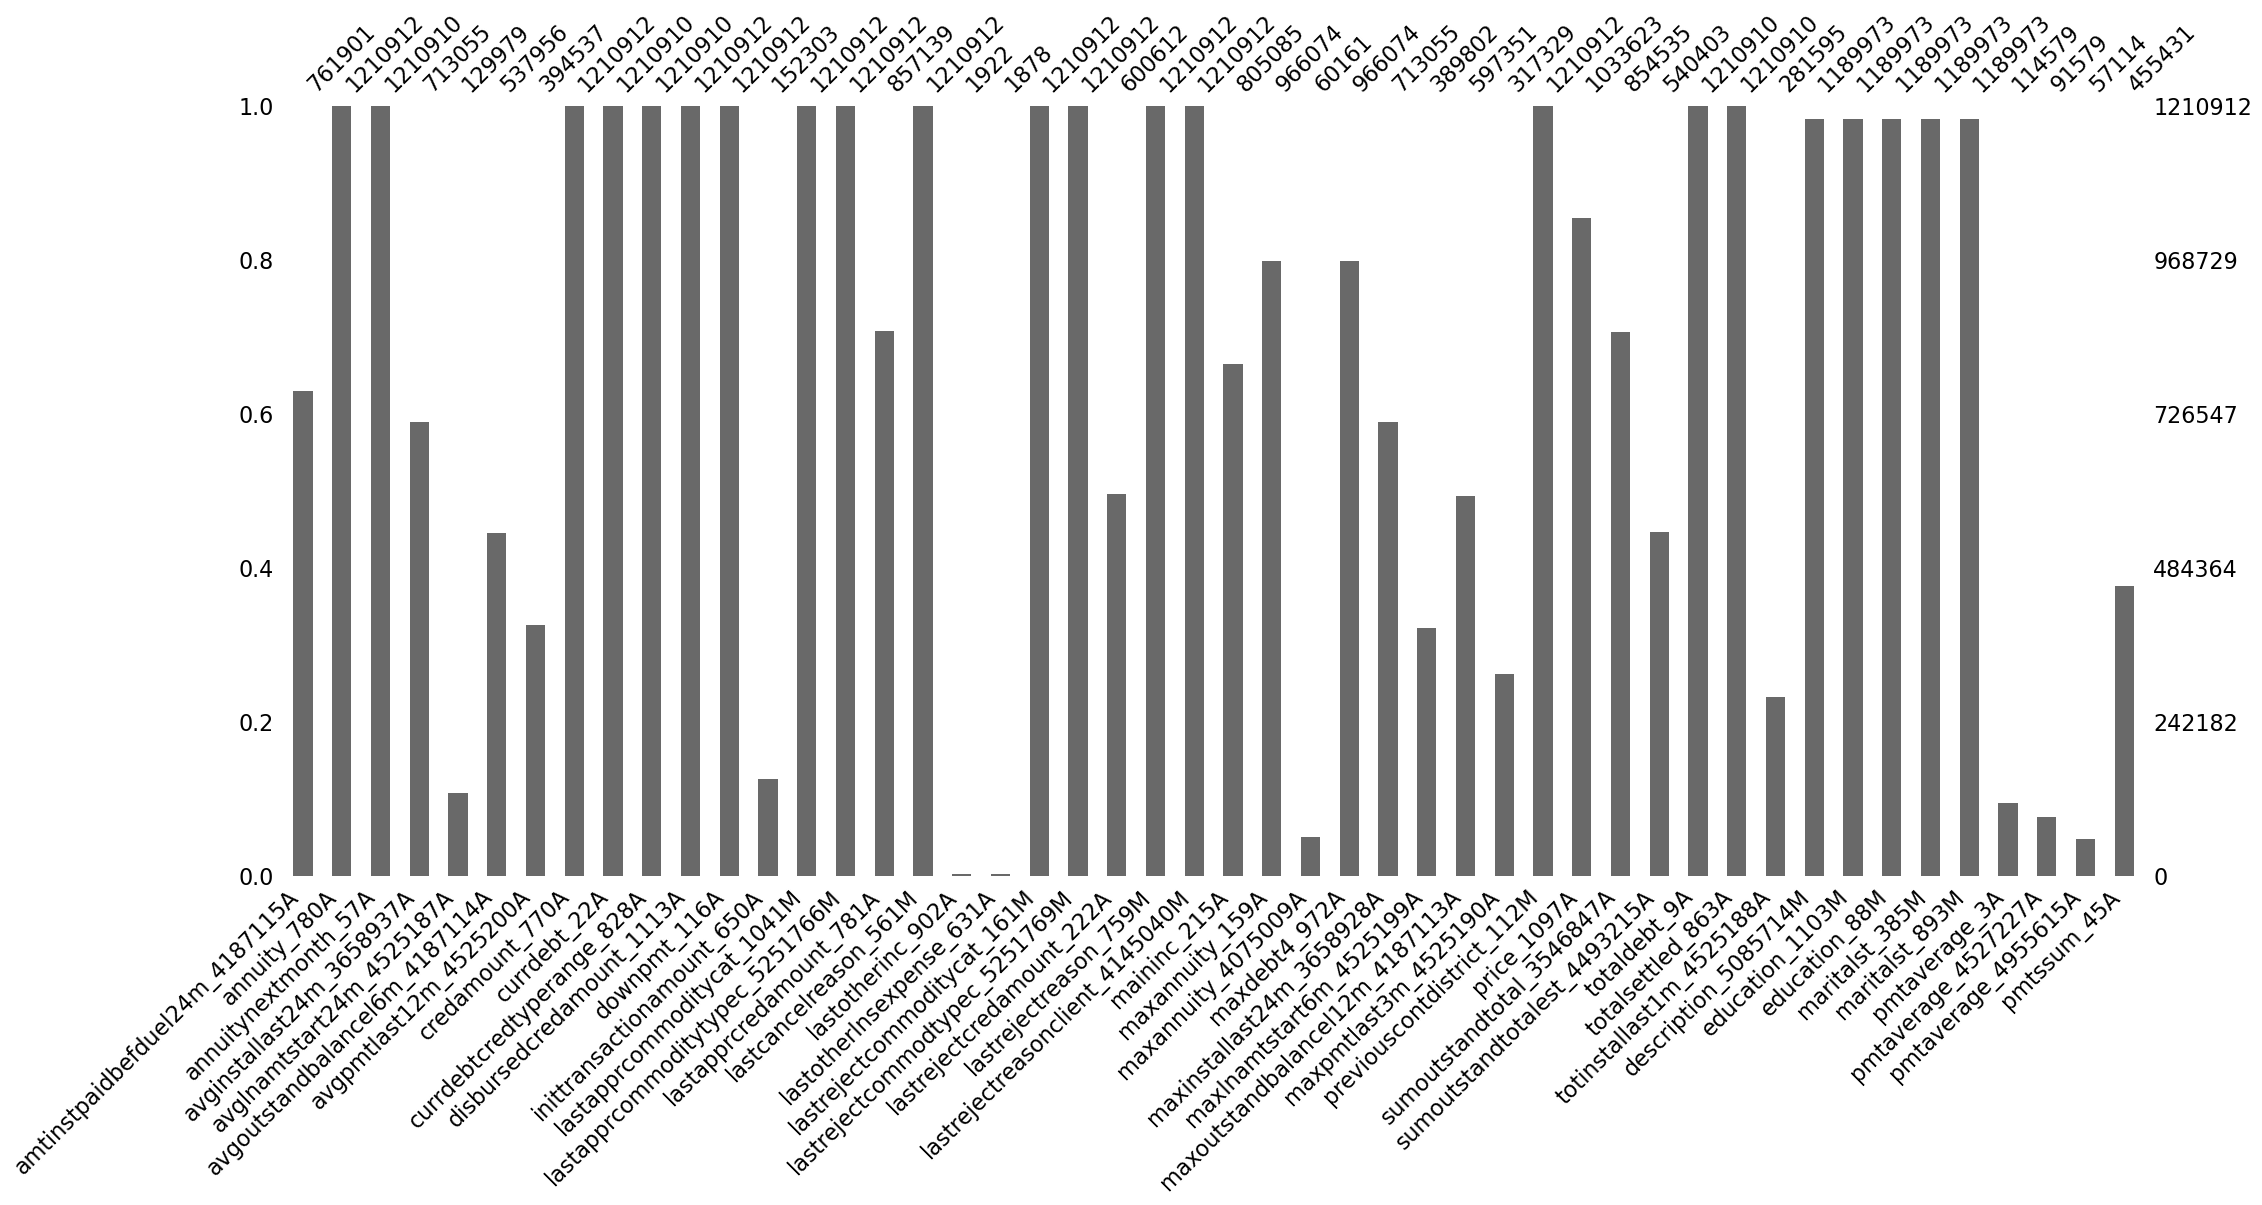

In [26]:
msno.bar(X_train)

Let's start with tree regression, and set Nan values to -1 just to set the threshold, and specify the data is missing from this row

In [27]:
# Fill NaN values with -1 in the specified columns
X_train['lastotherinc_902A'] = X_train['lastotherinc_902A'].fillna(-1) #Amount of other income reported by the client in their last application.
X_train['lastotherlnsexpense_631A'] = X_train['lastotherlnsexpense_631A'].fillna(-1) #Monthly expenses on other loans from the last application.
X_train['amtinstpaidbefduel24m_4187115A'] = X_train['amtinstpaidbefduel24m_4187115A'].fillna(-1) #Number of instalments paid before due date in the last 24 months.
X_train['avglnamtstart24m_4525187A'] = X_train['avglnamtstart24m_4525187A'].fillna(-1) #Average loan amount in the last 24 months.
X_train['avginstallast24m_3658937A'] = X_train['avginstallast24m_3658937A'].fillna(-1) #Average instalments paid by the client over the past 24 months.
X_train['avgoutstandbalancel6m_4187114A'] = X_train['avgoutstandbalancel6m_4187114A'].fillna(-1) #Average outstanding balance of applicant for the last 6 months.
X_train['avgpmtlast12m_4525200A'] = X_train['avgpmtlast12m_4525200A'].fillna(-1) #Average of payments made by the client in the last 12 months.
X_train['inittransactionamount_650A'] = X_train['inittransactionamount_650A'].fillna(-1) #Initial transaction amount of the credit application.
X_train['lastapprcredamount_781A'] = X_train['lastapprcredamount_781A'].fillna(-1) #Credit amount from the client's last application.
X_train['lastrejectcredamount_222A'] = X_train['lastrejectcredamount_222A'].fillna(-1) #Credit amount on last rejected application.
X_train['maininc_215A'] = X_train['maininc_215A'].fillna(-1) #Client's primary income amount.
X_train['maxannuity_159A'] = X_train['maxannuity_159A'].fillna(-1) #Maximum annuity previously obtained by client.
X_train['maxannuity_4075009A'] = X_train['maxannuity_4075009A'].fillna(-1) #Maximal annuity offered to the client in the current application.
X_train['maxdebt4_972A'] = X_train['maxdebt4_972A'].fillna(-1) #Maximal principal debt of the client in the history older than 4 months.
X_train['maxinstallast24m_3658928A'] = X_train['maxinstallast24m_3658928A'].fillna(-1) #Maximum instalment in the last 24 months.
X_train['maxlnamtstart6m_4525199A'] = X_train['maxlnamtstart6m_4525199A'].fillna(-1) #Maximum loan amount started in the last 6 months.
X_train['maxoutstandbalancel12m_4187113A'] = X_train['maxoutstandbalancel12m_4187113A'].fillna(-1) #Maximum outstanding balance in the last 12 months.
X_train['maxpmtlast3m_4525190A'] = X_train['maxpmtlast3m_4525190A'].fillna(-1) #Maximum payment made by the client in the last 3 months.
X_train['price_1097A'] = X_train['price_1097A'].fillna(-1) #Credit price.
X_train['sumoutstandtotal_3546847A'] = X_train['sumoutstandtotal_3546847A'].fillna(-1) #Sum of total outstanding amount.
X_train['sumoutstandtotalest_4493215A'] = X_train['sumoutstandtotalest_4493215A'].fillna(-1) #Sum of total outstanding amount.
X_train['totinstallast1m_4525188A'] = X_train['totinstallast1m_4525188A'].fillna(-1) #Total amount of monthly instalments paid in the previous month.
X_train['pmtaverage_3A'] = X_train['pmtaverage_3A'].fillna(-1) #Average of tax deductions.
X_train['pmtaverage_4527227A'] = X_train['pmtaverage_4527227A'].fillna(-1) #Average of tax deductions.
X_train['pmtaverage_4955615A'] = X_train['pmtaverage_4955615A'].fillna(-1) #Average of tax deductions.
X_train['pmtaverage_4955615A'] = X_train['pmtaverage_4955615A'].fillna(-1) #Average of tax deductions.
X_train['pmtssum_45A'] = X_train['pmtssum_45A'].fillna(-1) #Sum of tax deductions for the client.






In [28]:
# Get indices of rows with NaN values in 'description_5085714M' column
nan_indices = X_train[X_train['description_5085714M'].isna()].index

# Remove these rows from X_train
X_train = X_train.drop(nan_indices)

# Remove the corresponding rows from y_train and base_train
y_train = y_train.drop(nan_indices)
base_train = base_train.drop(nan_indices)

In [29]:
nan_rows = X_train[X_train['annuitynextmonth_57A'].isna()]
print(nan_rows)

        amtinstpaidbefduel24m_4187115A  annuity_780A  annuitynextmonth_57A  \
394038                            -1.0     2159.8000                   NaN   
394447                            -1.0     1222.2001                   NaN   

        avginstallast24m_3658937A  avglnamtstart24m_4525187A  \
394038                       -1.0                       -1.0   
394447                       -1.0                       -1.0   

        avgoutstandbalancel6m_4187114A  avgpmtlast12m_4525200A  \
394038                            -1.0                    -1.0   
394447                            -1.0                    -1.0   

        credamount_770A  currdebt_22A  currdebtcredtyperange_828A  ...  \
394038          35998.0           NaN                         NaN  ...   
394447          21998.0           NaN                         NaN  ...   

        totinstallast1m_4525188A  description_5085714M  education_1103M  \
394038                      -1.0              a55475b1         a55475b1   


In [30]:
#remove that strange row with strange nan values
# Find the indices where 'annuitynextmonth_57A' is NaN
nan_indices = X_train[X_train['annuitynextmonth_57A'].isna()].index

# Drop these indices from the dataframes
X_train = X_train.drop(nan_indices)
y_train = y_train.drop(nan_indices)
base_train = base_train.drop(nan_indices)

<Axes: >

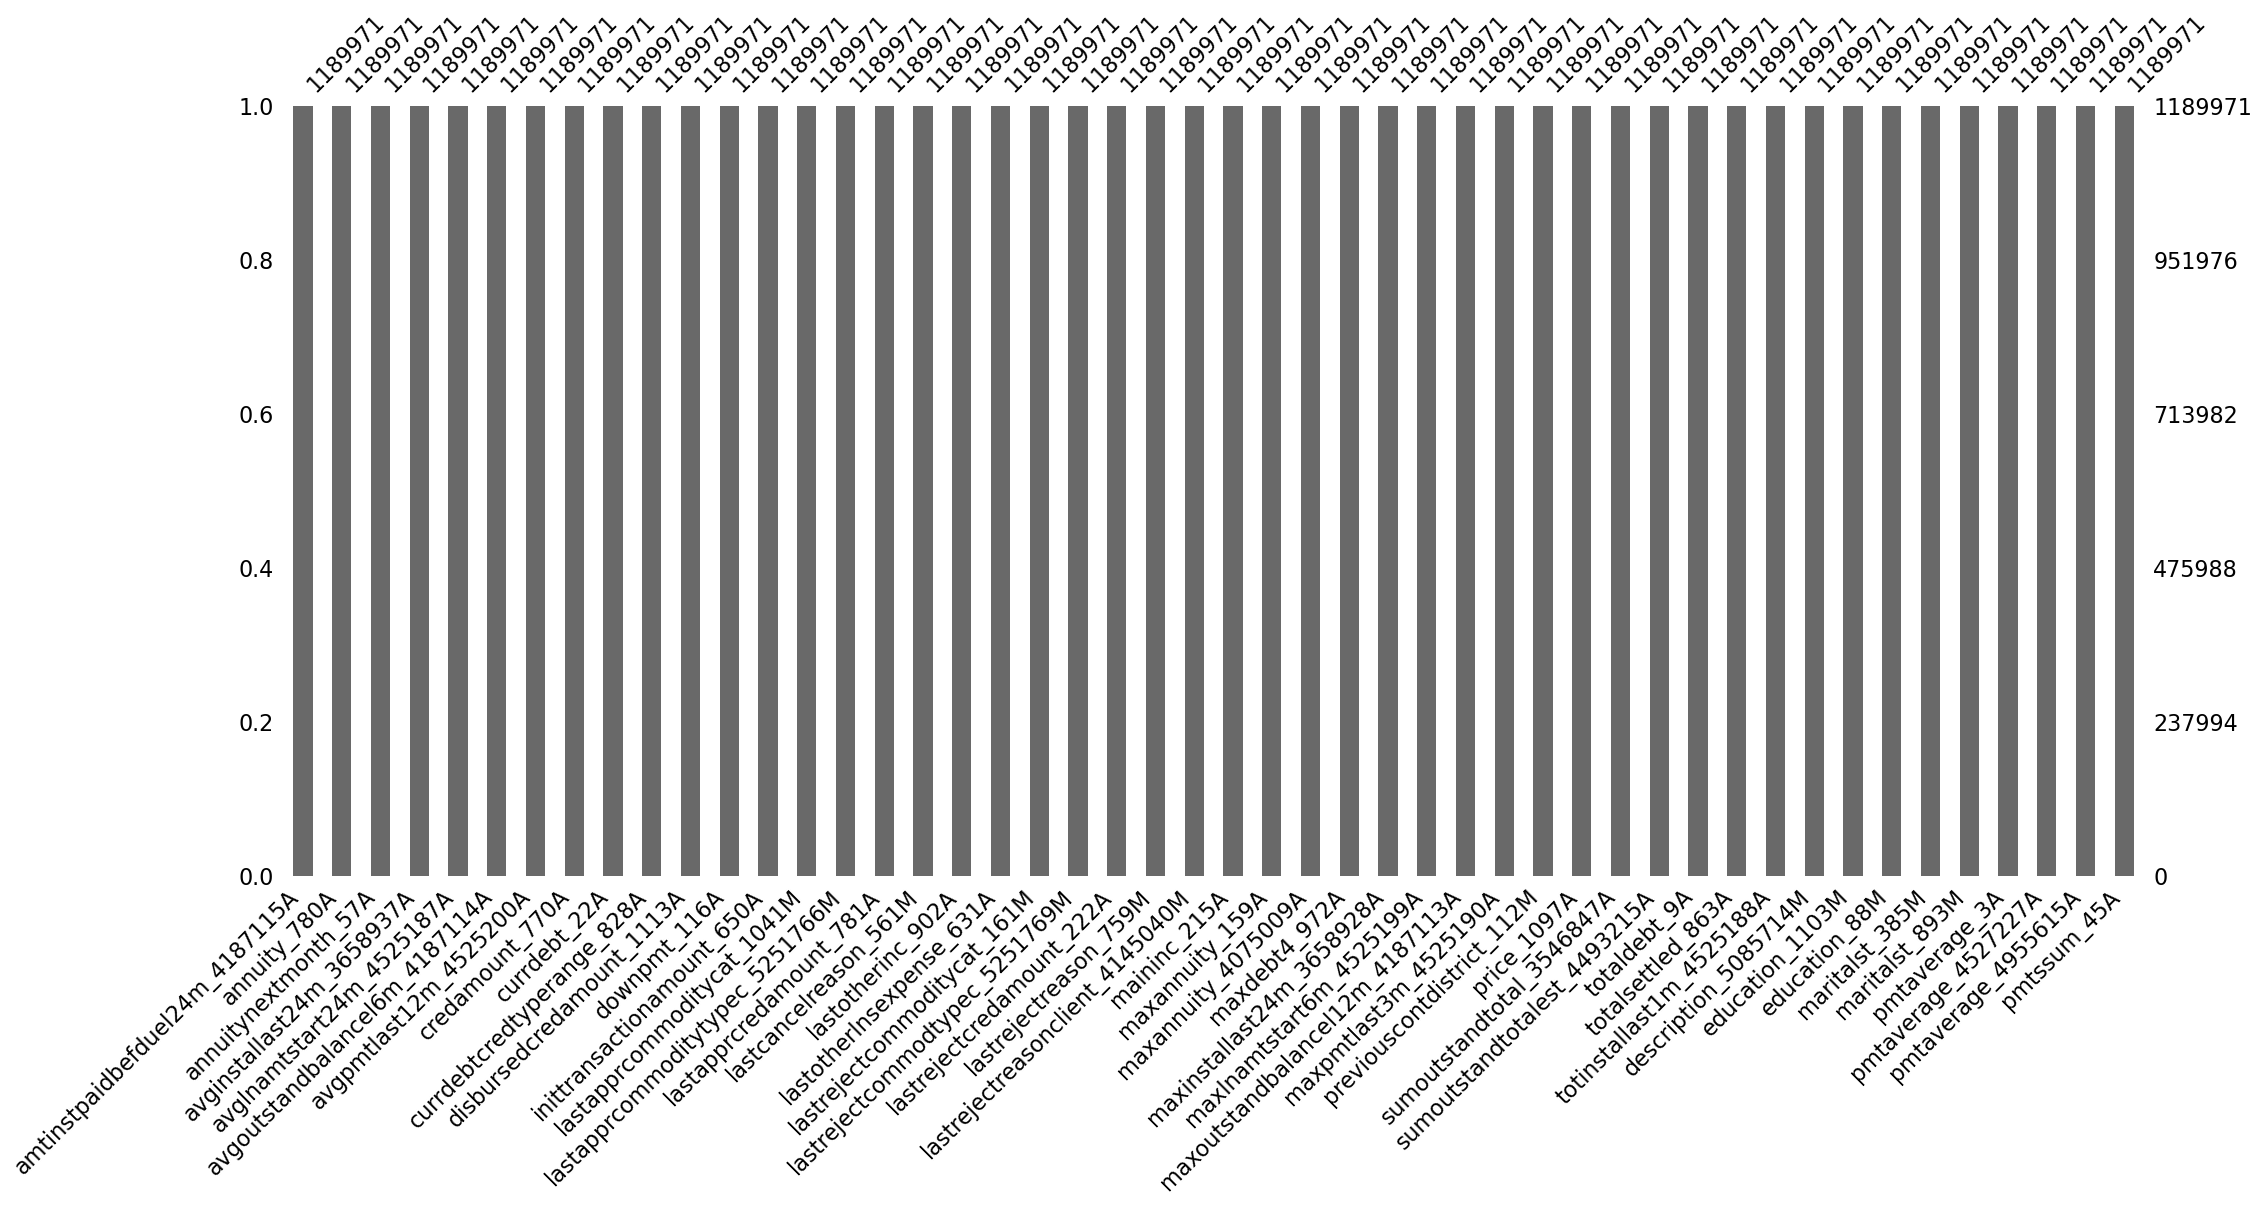

In [31]:
msno.bar(X_train)


<Axes: >

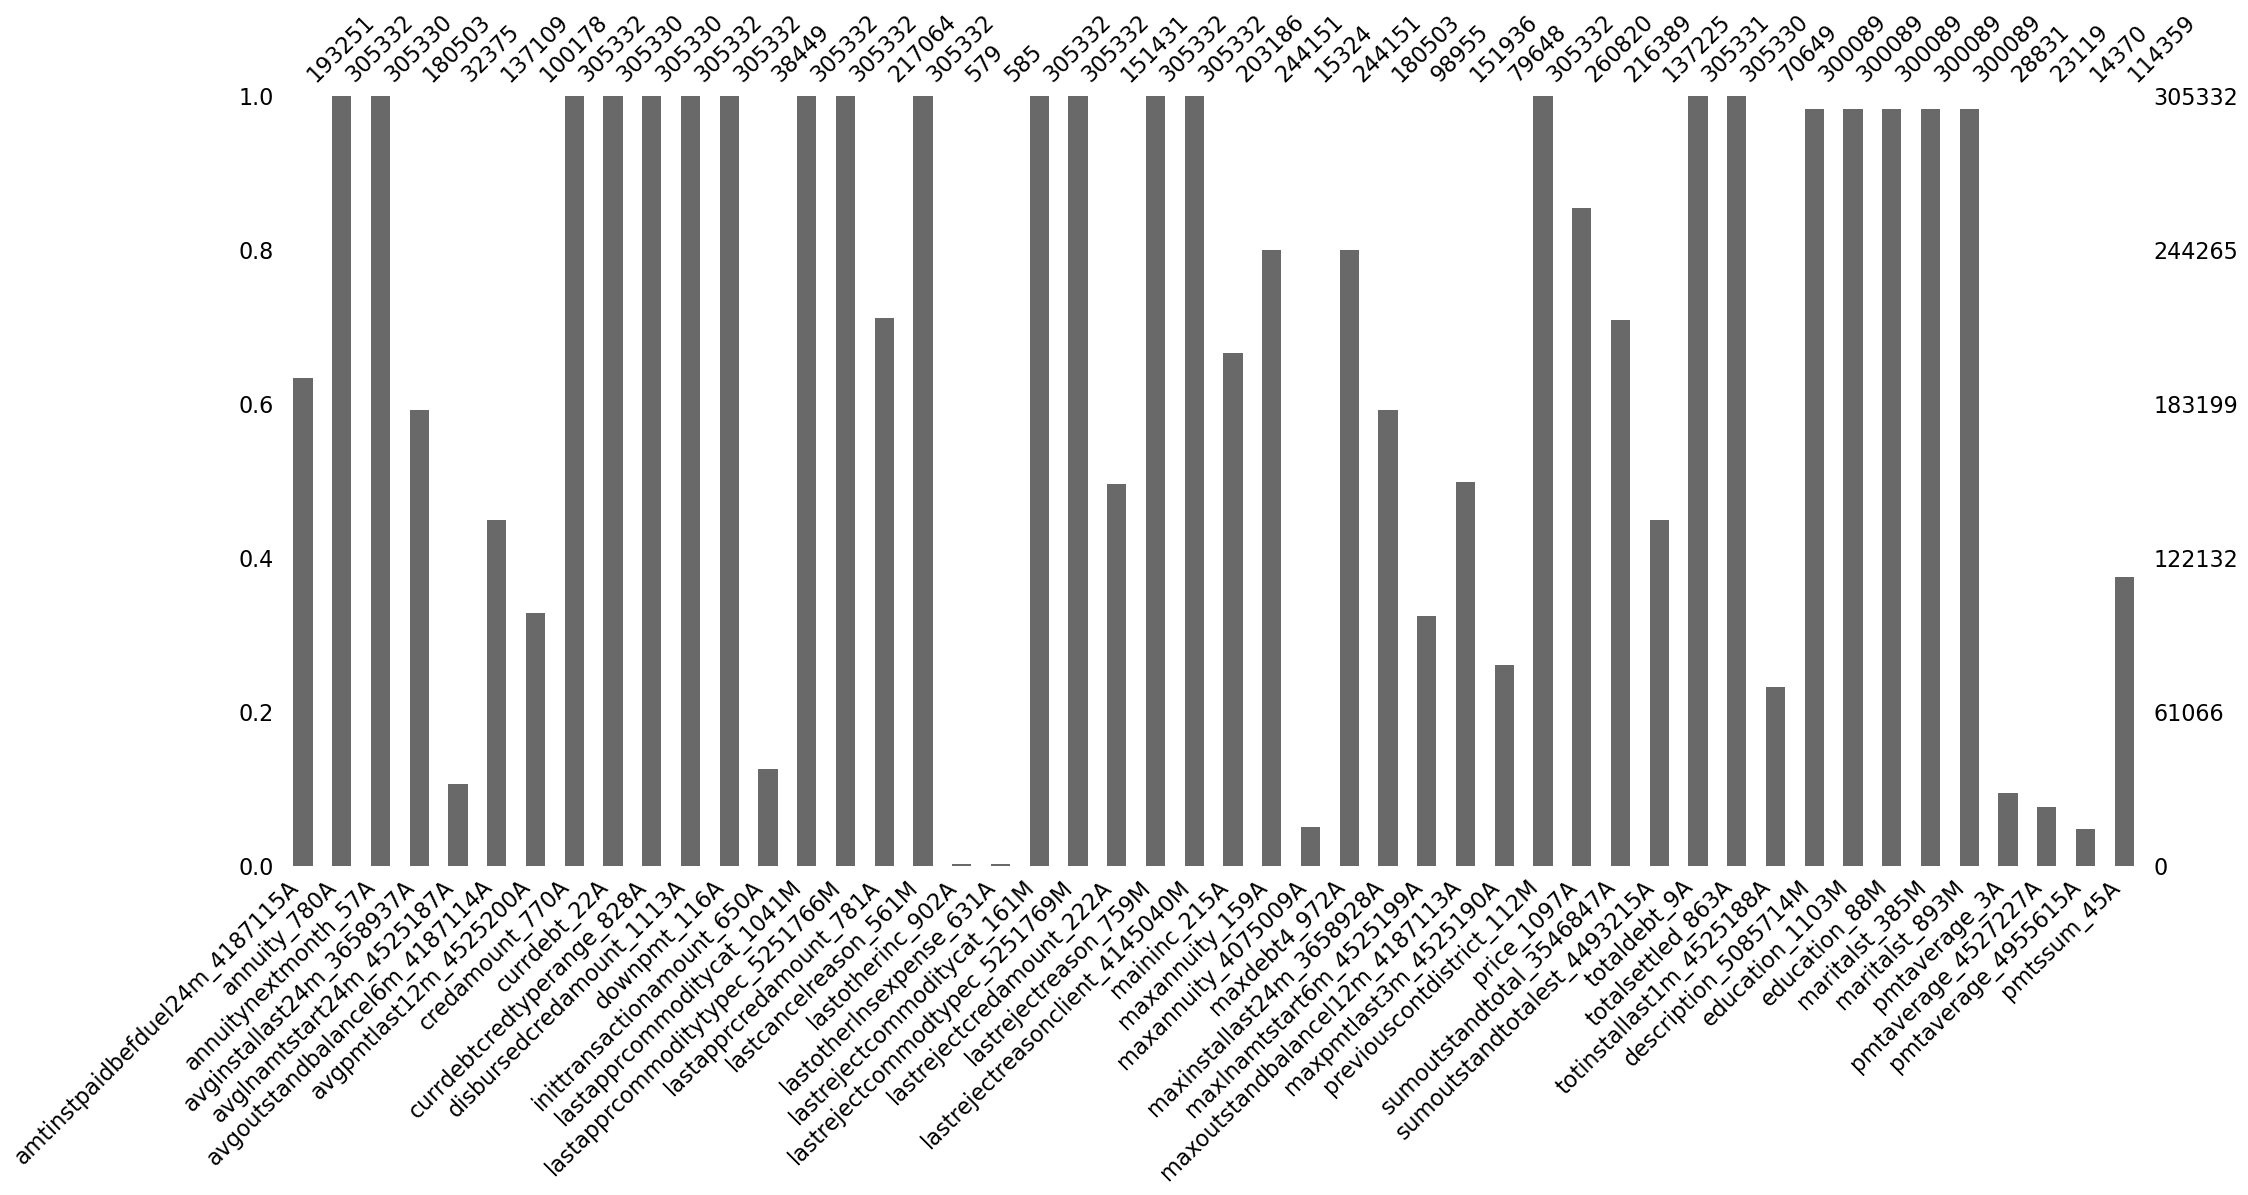

In [32]:
msno.bar(X_test)


In [33]:
#fill NaN values with -1 in the specified columns for datafraem X_test
X_test['lastotherinc_902A'] = X_test['lastotherinc_902A'].fillna(-1) #Amount of other income reported by the client in their last application.
X_test['lastotherlnsexpense_631A'] = X_test['lastotherlnsexpense_631A'].fillna(-1) #Monthly expenses on other loans from the last application.
X_test['amtinstpaidbefduel24m_4187115A'] = X_test['amtinstpaidbefduel24m_4187115A'].fillna(-1) #Number of instalments paid before due date in the last 24 months.
X_test['avglnamtstart24m_4525187A'] = X_test['avglnamtstart24m_4525187A'].fillna(-1) #Average loan amount in the last 24 months.
X_test['avginstallast24m_3658937A'] = X_test['avginstallast24m_3658937A'].fillna(-1) #Average instalments paid by the client over the past 24 months.
X_test['avgoutstandbalancel6m_4187114A'] = X_test['avgoutstandbalancel6m_4187114A'].fillna(-1) #Average outstanding balance of applicant for the last 6 months.
X_test['avgpmtlast12m_4525200A'] = X_test['avgpmtlast12m_4525200A'].fillna(-1) #Average of payments made by the client in the last 12 months.
X_test['inittransactionamount_650A'] = X_test['inittransactionamount_650A'].fillna(-1) #Initial transaction amount of the credit application.
X_test['lastapprcredamount_781A'] = X_test['lastapprcredamount_781A'].fillna(-1) #Credit amount from the client's last application.
X_test['lastrejectcredamount_222A'] = X_test['lastrejectcredamount_222A'].fillna(-1) #Credit amount on last rejected application.
X_test['maininc_215A'] = X_test['maininc_215A'].fillna(-1) #Client's primary income amount.
X_test['maxannuity_159A'] = X_test['maxannuity_159A'].fillna(-1) #Maximum annuity previously obtained by client.
X_test['maxannuity_4075009A'] = X_test['maxannuity_4075009A'].fillna(-1) #Maximal annuity offered to the client in the current application.
X_test['maxdebt4_972A'] = X_test['maxdebt4_972A'].fillna(-1) #Maximal principal debt of the client in the history older than 4 months.
X_test['maxinstallast24m_3658928A'] = X_test['maxinstallast24m_3658928A'].fillna(-1) #Maximum instalment in the last 24 months.
X_test['maxlnamtstart6m_4525199A'] = X_test['maxlnamtstart6m_4525199A'].fillna(-1) #Maximum loan amount started in the last 6 months.
X_test['maxoutstandbalancel12m_4187113A'] = X_test['maxoutstandbalancel12m_4187113A'].fillna(-1) #Maximum outstanding balance in the last 12 months.
X_test['maxpmtlast3m_4525190A'] = X_test['maxpmtlast3m_4525190A'].fillna(-1) #Maximum payment made by the client in the last 3 months.
X_test['price_1097A'] = X_test['price_1097A'].fillna(-1) #Credit price.
X_test['sumoutstandtotal_3546847A'] = X_test['sumoutstandtotal_3546847A'].fillna(-1) #Sum of total outstanding amount.
X_test['sumoutstandtotalest_4493215A'] = X_test['sumoutstandtotalest_4493215A'].fillna(-1) #Sum of total outstanding amount.
X_test['totinstallast1m_4525188A'] = X_test['totinstallast1m_4525188A'].fillna(-1) #Total amount of monthly instalments paid in the previous month.
X_test['pmtaverage_3A'] = X_test['pmtaverage_3A'].fillna(-1) #Average of tax deductions.
X_test['pmtaverage_4527227A'] = X_test['pmtaverage_4527227A'].fillna(-1) #Average of tax deductions.
X_test['pmtaverage_4955615A'] = X_test['pmtaverage_4955615A'].fillna(-1) #Average of tax deductions.
X_test['pmtaverage_4955615A'] = X_test['pmtaverage_4955615A'].fillna(-1) #Average of tax deductions.
X_test['pmtssum_45A'] = X_test['pmtssum_45A'].fillna(-1) #Sum of tax deductions for the client.



<Axes: >

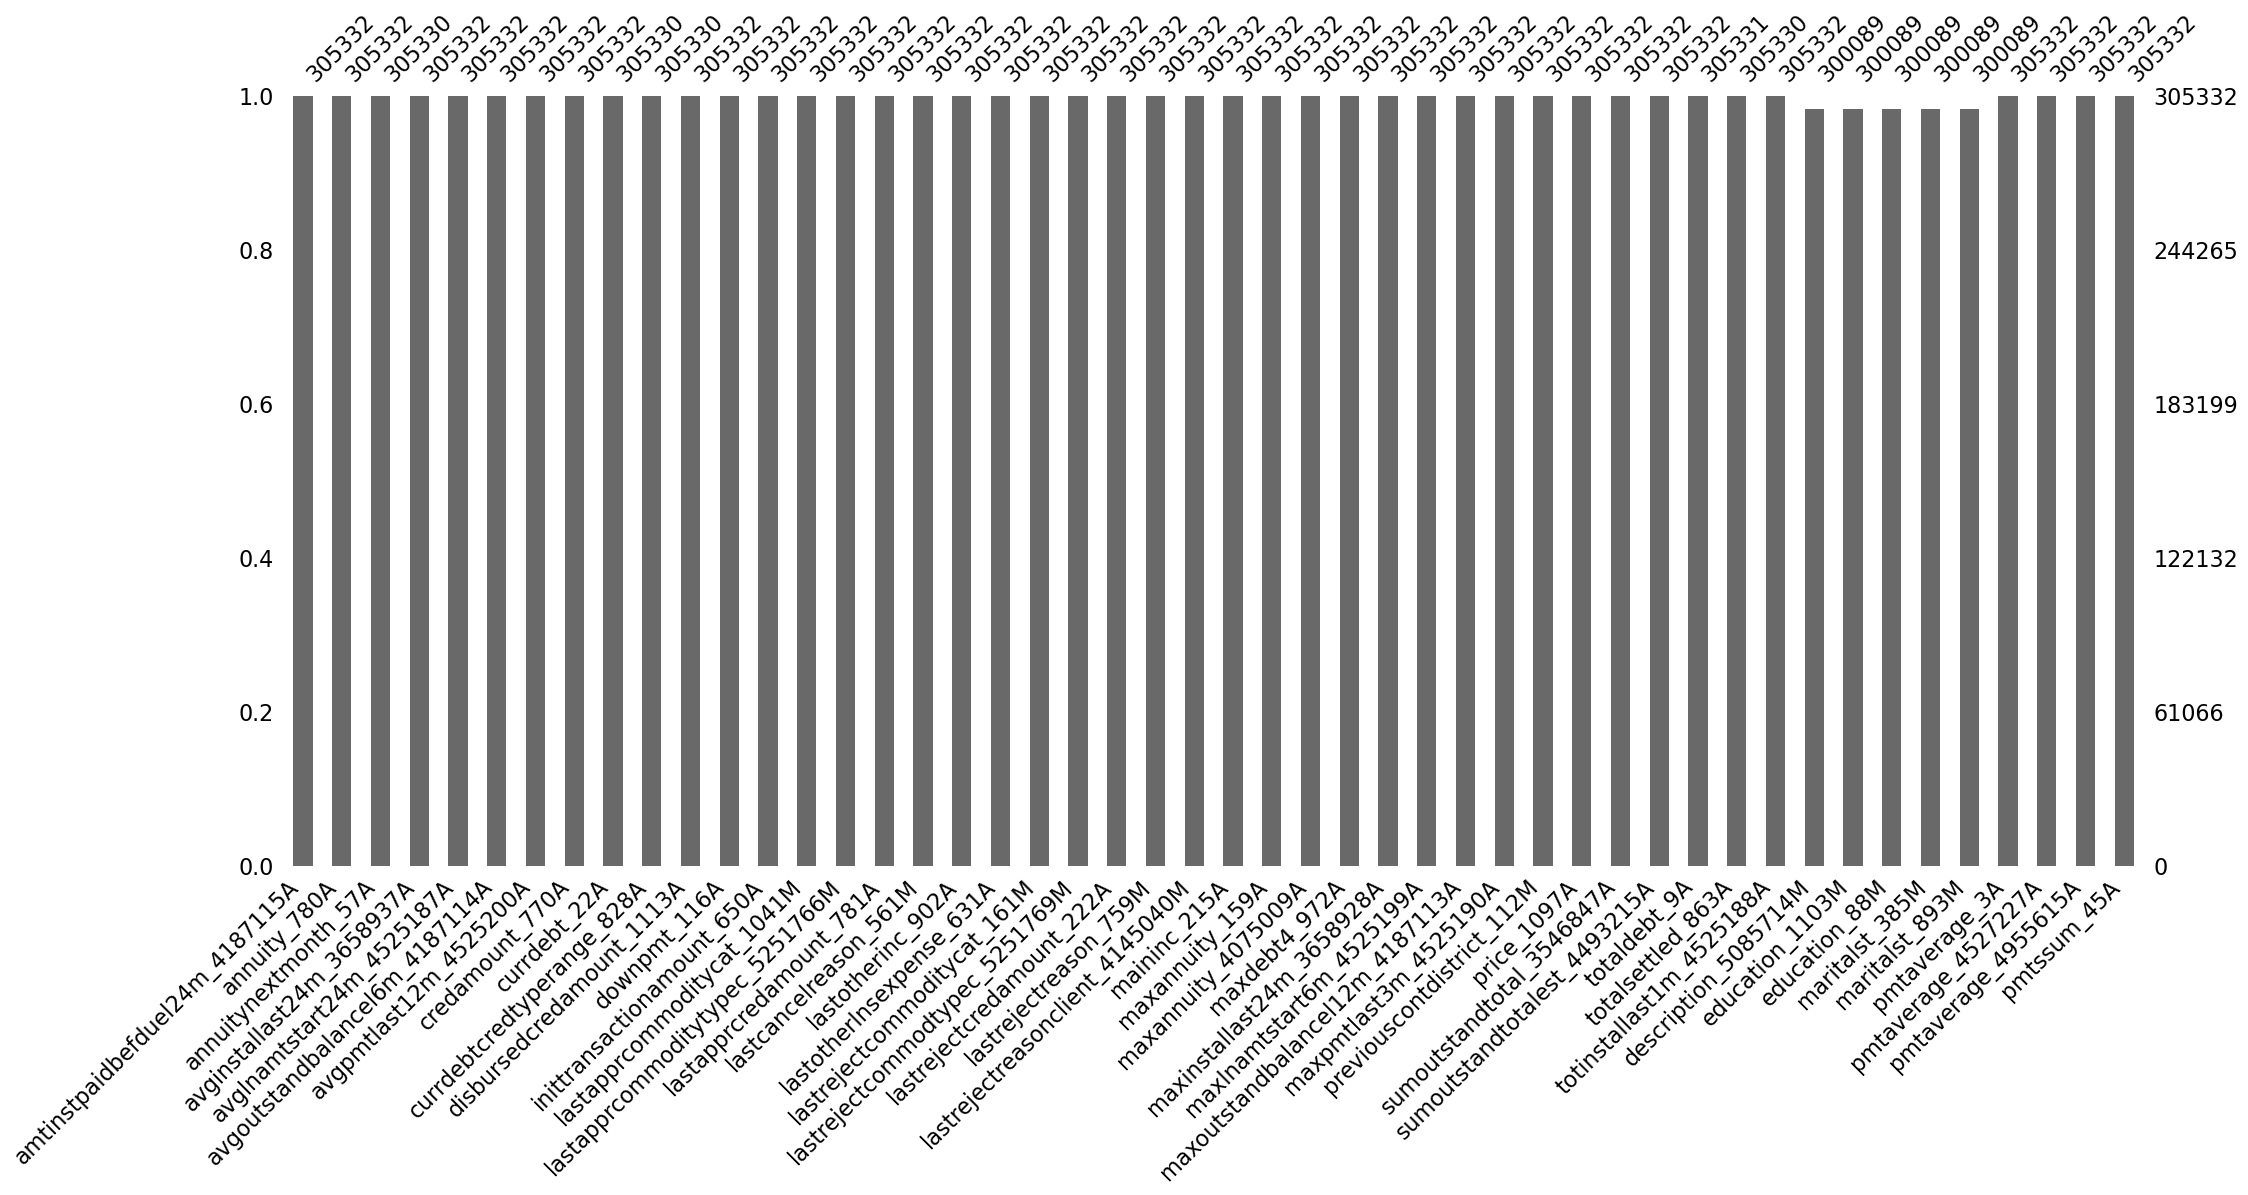

In [34]:
msno.bar(X_test)

Start working on a balanced dataset

In [35]:
#Start with Naive random over-sampling

from imblearn.over_sampling import RandomOverSampler

# create the object with the desired sampling strategy.
ros = RandomOverSampler(sampling_strategy='minority')

# fit the object to the training data.
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

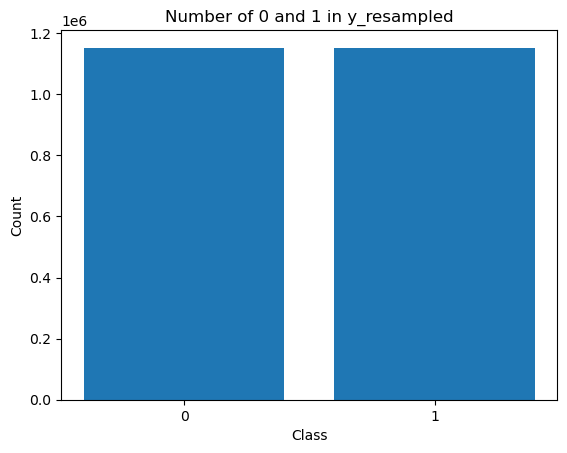

In [36]:
#Visualise the new oversampled dataset

# Count the number of 0s and 1s
counts = y_resampled.value_counts()

# Create a bar chart
plt.bar(counts.index, counts.values)

# Label the x-axis and y-axis
plt.xlabel('Class')
plt.ylabel('Count')

# Add a title
plt.title('Number of 0 and 1 in y_resampled')

# Specify the x-axis tick marks
plt.xticks([0, 1])

# Show the plot
plt.show()

In [37]:
print(f"Train: {X_resampled.shape}, Type: {type(X_resampled)}")
print(f"Test: {y_resampled.shape}, Type: {type(y_resampled)}")


Train: (2304982, 48), Type: <class 'pandas.core.frame.DataFrame'>
Test: (2304982,), Type: <class 'pandas.core.series.Series'>


In [38]:
from sklearn.preprocessing import OrdinalEncoder

# Specify the columns to be ordinal encoded
ordinal_cols = ['lastapprcommoditycat_1041M', 'lastapprcommoditytypec_5251766M', 'lastcancelreason_561M','lastrejectcommoditycat_161M','lastrejectcommodtypec_5251769M','lastrejectreason_759M','lastrejectreasonclient_4145040M','previouscontdistrict_112M','description_5085714M','education_1103M','education_88M','maritalst_385M','maritalst_893M']  # replace with your column names

# Create the ordinal encoder
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1)

# Fit the encoder and transform X_train
X_resampled_encoded = X_resampled.copy()
X_resampled_encoded[ordinal_cols] = encoder.fit_transform(X_resampled[ordinal_cols])

# Transform X_test using the same encoder
X_test_encoded = X_test.copy()
X_test_encoded[ordinal_cols] = encoder.transform(X_test[ordinal_cols])

In [39]:
print("X_resampled_encoded shape", X_resampled_encoded.shape)
print("X_test_encoded shape", X_test_encoded.shape)

X_resampled_encoded shape (2304982, 48)
X_test_encoded shape (305332, 48)


In [40]:
categorical_columns = X_resampled.select_dtypes(include=['category'])
unique_counts = categorical_columns.nunique()
print(unique_counts)

lastapprcommoditycat_1041M          45
lastapprcommoditytypec_5251766M    198
lastcancelreason_561M               73
lastrejectcommoditycat_161M         44
lastrejectcommodtypec_5251769M     176
lastrejectreason_759M               18
lastrejectreasonclient_4145040M     14
previouscontdistrict_112M          223
description_5085714M                 2
education_1103M                      5
education_88M                        5
maritalst_385M                       6
maritalst_893M                       6
dtype: int64


In [41]:
print(X_resampled.shape)
print(X_test.shape)
print("X_resampled_encoded shape", X_resampled_encoded.shape)
print("X_test_encoded shape", X_test_encoded.shape)

(2304982, 48)
(305332, 48)
X_resampled_encoded shape (2304982, 48)
X_test_encoded shape (305332, 48)


In [42]:


#fill NaN values with -1 in the specified columns for datafraem X_test_encoded
X_test_encoded['annuitynextmonth_57A'] = X_test_encoded['annuitynextmonth_57A'].fillna(-1) #Amount of other income reported by the client in their last application.
X_test_encoded['currdebt_22A'] = X_test_encoded['currdebt_22A'].fillna(-1) #Amount of other income reported by the client in their last application.
X_test_encoded['currdebtcredtyperange_828A'] = X_test_encoded['currdebtcredtyperange_828A'].fillna(-1) #Amount of other income reported by the client in their last application.
X_test_encoded['totaldebt_9A'] = X_test_encoded['totaldebt_9A'].fillna(-1) #Amount of other income reported by the client in their last application.
X_test_encoded['totalsettled_863A'] = X_test_encoded['totalsettled_863A'].fillna(-1) #Amount of other income reported by the client in their last application.

#count how many na in X_test_encoded
print(X_test_encoded.isna().sum())

amtinstpaidbefduel24m_4187115A     0
annuity_780A                       0
annuitynextmonth_57A               0
avginstallast24m_3658937A          0
avglnamtstart24m_4525187A          0
avgoutstandbalancel6m_4187114A     0
avgpmtlast12m_4525200A             0
credamount_770A                    0
currdebt_22A                       0
currdebtcredtyperange_828A         0
disbursedcredamount_1113A          0
downpmt_116A                       0
inittransactionamount_650A         0
lastapprcommoditycat_1041M         0
lastapprcommoditytypec_5251766M    0
lastapprcredamount_781A            0
lastcancelreason_561M              0
lastotherinc_902A                  0
lastotherlnsexpense_631A           0
lastrejectcommoditycat_161M        0
lastrejectcommodtypec_5251769M     0
lastrejectcredamount_222A          0
lastrejectreason_759M              0
lastrejectreasonclient_4145040M    0
maininc_215A                       0
maxannuity_159A                    0
maxannuity_4075009A                0
m

In [43]:
#Scale

from sklearn.preprocessing import MaxAbsScaler

# Create a scaler object
scaler = MaxAbsScaler()

# Fit the scaler to the training data and transform it
X_resampled_encoded_scaled = scaler.fit_transform(X_resampled_encoded)

# Transform the test data using the same scaler
X_test_encoded_scaled = scaler.transform(X_test_encoded)


Start a simple machine learning, decision tree

In [44]:
# Decision tree exmaple
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, classification_report

decision_tree_model = DecisionTreeClassifier(random_state=0, class_weight='balanced')
decision_tree_model = decision_tree_model.fit(X_resampled_encoded_scaled, y_resampled)


In [45]:

y_pred = decision_tree_model.predict(X_test_encoded_scaled)
# Compute the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)

# Evaluate the model
accuracy_dt = accuracy_score(y_test, y_pred)
print(f"Decision Tree Accuracy: {accuracy_dt}")
print("Decision Tree Classification Report:")
print(classification_report(y_test, y_pred))


Decision Tree Accuracy: 0.9383982026122385
Decision Tree Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    295689
           1       0.07      0.08      0.08      9643

    accuracy                           0.94    305332
   macro avg       0.52      0.52      0.52    305332
weighted avg       0.94      0.94      0.94    305332



In [46]:
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create a base model
rf = RandomForestClassifier(random_state=42, n_jobs=-1
                            )

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=KFold(n_splits=5), verbose=2, n_jobs=-1)

# Fit the grid search to the data
grid_search.fit(X_resampled_encoded, y_resampled)

# Get the best parameters
best_params = grid_search.best_params_
print(best_params)

# Get the best estimator
best_estimator = grid_search.best_estimator_

# Predict on the test data
y_pred = best_estimator.predict(X_test_encoded)

# Evaluate the model
print('Test Accuracy:', accuracy_score(y_test, y_pred))
"""



"\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import GridSearchCV, KFold\n\n# Define the parameter grid\nparam_grid = {\n    'n_estimators': [100, 200, 300],\n    'max_depth': [None, 5, 10],\n    'min_samples_split': [2, 5, 10]\n}\n\n# Create a base model\nrf = RandomForestClassifier(random_state=42, n_jobs=-1\n                            )\n\n# Instantiate the grid search model\ngrid_search = GridSearchCV(estimator=rf, param_grid=param_grid, \n                           cv=KFold(n_splits=5), verbose=2, n_jobs=-1)\n\n# Fit the grid search to the data\ngrid_search.fit(X_resampled_encoded, y_resampled)\n\n# Get the best parameters\nbest_params = grid_search.best_params_\nprint(best_params)\n\n# Get the best estimator\nbest_estimator = grid_search.best_estimator_\n\n# Predict on the test data\ny_pred = best_estimator.predict(X_test_encoded)\n\n# Evaluate the model\nprint('Test Accuracy:', accuracy_score(y_test, y_pred))\n"

In [49]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create a base model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
                           cv=KFold(n_splits=5), verbose=2, n_jobs=-1)

# Create a subset of the data
X_subset = X_resampled_encoded_scaled[:100000]
y_subset = y_resampled[:100000]

# Fit the grid search to the data
grid_search.fit(X_subset, y_subset)

# Get the best parameters
best_params = grid_search.best_params_
print(best_params)

# Get the best estimator
best_estimator = grid_search.best_estimator_

# Predict on the test data
y_pred = best_estimator.predict(X_test_encoded_scaled)

# Evaluate the model
print('Test Accuracy:', accuracy_score(y_test, y_pred))

# Print classification report
print(classification_report(y_test, y_pred))

Fitting 5 folds for each of 27 candidates, totalling 135 fits
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  18.3s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  19.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  20.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  23.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=100; total time=  23.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  40.6s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  46.7s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  47.2s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  35.8s
[CV] END max_depth=None, min_samples_split=2, n_estimators=200; total time=  39.0s
[CV] END max_depth=None, min_samples_split=5, n_estimators=100; total time=  25.0s
[CV] END max_depth=None, 

/Users/ronaldleung/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/ronaldleung/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.97      1.00      0.98    295689
           1       0.00      0.00      0.00      9643

    accuracy                           0.97    305332
   macro avg       0.48      0.50      0.49    305332
weighted avg       0.94      0.97      0.95    305332



/Users/ronaldleung/anaconda3/lib/python3.11/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
#Random forest with CV for the full dataset
"""
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.metrics import classification_report

# Define the parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5, 10]
}

# Create a base model
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

# Instantiate the grid search model
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, 
ß                           cv=KFold(n_splits=5), verbose=2, n_jobs=-1)


# Fit the grid search to the data
grid_search.fit(X_resampled_encoded_scaled, y_resampled)

# Get the best parameters
best_params = grid_search.best_params_
print(best_params)

# Get the best estimator
best_estimator = grid_search.best_estimator_

# Predict on the test data
y_pred = best_estimator.predict(X_test_encoded_scaled)

# Evaluate the model
print('Test Accuracy:', accuracy_score(y_test, y_pred))

# Print classification report
print(classification_report(y_test, y_pred))

"""

"\nfrom sklearn.ensemble import RandomForestClassifier\nfrom sklearn.model_selection import GridSearchCV, KFold\nfrom sklearn.metrics import classification_report\n\n# Define the parameter grid\nparam_grid = {\n    'n_estimators': [100, 200, 300],\n    'max_depth': [None, 5, 10],\n    'min_samples_split': [2, 5, 10]\n}\n\n# Create a base model\nrf = RandomForestClassifier(random_state=42, n_jobs=-1)\n\n# Instantiate the grid search model\ngrid_search = GridSearchCV(estimator=rf, param_grid=param_grid, \nß                           cv=KFold(n_splits=5), verbose=2, n_jobs=-1)\n\n\n# Fit the grid search to the data\ngrid_search.fit(X_resampled_encoded_scaled, y_resampled)\n\n# Get the best parameters\nbest_params = grid_search.best_params_\nprint(best_params)\n\n# Get the best estimator\nbest_estimator = grid_search.best_estimator_\n\n# Predict on the test data\ny_pred = best_estimator.predict(X_test_encoded_scaled)\n\n# Evaluate the model\nprint('Test Accuracy:', accuracy_score(y_test, y

## Logistic Regression

In [ ]:
from sklearn.linear_model import LogisticRegression

# Initialize the Logistic Regression model
logistic_regression_model = LogisticRegression(random_state=0, max_iter=300, class_weight='balanced')

# Fit the model on the training data
logistic_regression_model.fit(X_train_df, y_train_small)

# Predict on the test data
y_pred_lr = logistic_regression_model.predict(X_test_df)

# Evaluate the model
accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f"Logistic Regression Accuracy: {accuracy_lr}")
print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))